### Imports et initialisations

In [54]:
import numpy as np
import random
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from clustertools import *

#répertoire dans lequel seront stockés les clusters, doit se terminer obligatoirement par /
cluster_dir = "clusters/Antisemite_Min_clusters/"

# Bien vérifier que le modèle d'encodage correspond au dataset
clean_dataset_file = "datasets/haine2022_oversampling_antisemiteMin.txt"
encoding_model_file = "models/w2vec_model_d300_global_Min"

raw_dataset_file = "datasets/haine2022_oversampling_antisemite.txt"

### Récupération des tweets

In [53]:
with open(clean_dataset_file, "r") as file:
    lines = file.readlines()
    
clean_dataset = [line.split() for line in lines]

with open(raw_dataset_file, "r") as file:
    raw_dataset = file.read().splitlines()

### Création des échantillons
Ne pas exécuter pour travailler avec toutes les données

In [3]:
sample_size = 5000

idx_list = random.sample(range(len(clean_dataset)), sample_size)
clean_dataset = [clean_dataset[i] for i in idx_list]
raw_dataset = [raw_dataset[i] for i in idx_list]

### Encodage du jeu de données

On charge le modèle depuis le disque

In [55]:
from gensim.models import KeyedVectors

In [56]:
model = KeyedVectors.load(encoding_model_file)
dim = 300

In [57]:
# Encode un message
# msg : liste de chaînes de caractères correspondant aux mots du message
# model : le modèle utilisé pour l'encodage
# dim : la dimension des vecteurs mots dans ce modèle
# Renvoie un vecteur qui est la moyenne de tous les vecteurs correspondants aux mots du message
# Si aucun mot du message n'est dans le modèle, renvoie un vecteur de zéros.
def encode(msg, model, dim):
    return np.mean([model[word] for word in msg if word in model] or [np.zeros(dim)], axis = 0)

In [58]:
%%time
#encodage de l'échantillon pour créer le jeu de données
dataset_encoded = np.array([encode(msg, model, dim) for msg in clean_dataset])


CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 147 ms


### Visualisation du dataset

- On réalise une réduction de dimension afin de visualiser les données dans une grille en deux dimensions
- On utilise pour cela la méthode PCA

In [59]:
%%time

pca = PCA(n_components=2)

#On crée une version en deux dimensions de notre jeu de données
two_dim_dataset = pca.fit_transform(dataset_encoded)

CPU times: user 487 ms, sys: 872 ms, total: 1.36 s
Wall time: 496 ms


In [60]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
b = two_dim_dataset.T

In [61]:
init_globals(clean_dataset, raw_dataset, two_dim_dataset, cluster_dir)

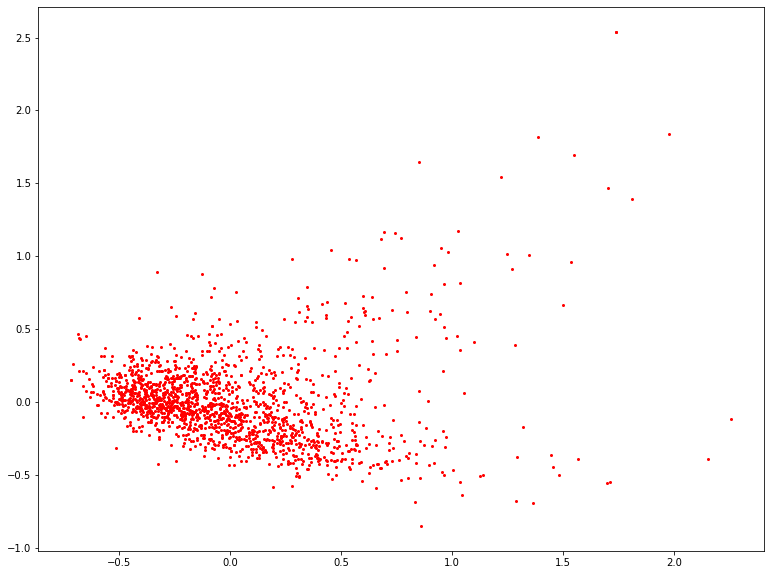

In [62]:
#Affichage des données
plt.plot(b[0], b[1], 'r.')
plt.show()

### SOM

In [63]:
from minisom import MiniSom

In [64]:
m = 3
n = 3
som = MiniSom(m, n, 300, neighborhood_function='gaussian', random_seed=0)
som.pca_weights_init(dataset_encoded)

In [65]:
%%time
som.train(dataset_encoded, 100000, verbose=True)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.9360203746064811
CPU times: user 16.5 s, sys: 3.88 s, total: 20.4 s
Wall time: 16.8 s


In [66]:
%%time
pred = []
for msg in dataset_encoded:
    winner = som.winner(msg)
    pred.append(winner[0]*n+winner[1])

CPU times: user 149 ms, sys: 270 ms, total: 419 ms
Wall time: 59.3 ms


In [67]:
centroids = []
for row in som.get_weights():
    for w in row:
        centroids.append(w)

In [68]:
centers = [[r[0] for r in model.similar_by_vector(c)] for c in centroids]

### Analyse et sauvegarde des résultats

Cluster 0 : 58 messages
57 messages contiennent un mot-clé haineux (soit 98.28%)
Les 20 mots les plus fréquents : t’es toi t juste suis moi dire mdr t’as dis c t’étais fais ton ta non j’ai va te trop 
Les mots les plus proches du centre : ressaisis-toi j’espère? narvalo oui???? singe? feignant t'accuse négre? khey fdp? 

Cluster 1 : 13 messages
10 messages contiennent un mot-clé haineux (soit 76.92%)
Les 20 mots les plus fréquents : mon me toi donne moi te tellement hé gnome mien aussi stp reste ta zone ah mairde, couzin mi si 
Les mots les plus proches du centre : hâter beacoup lézard, .mon pute?? filme. quelqu'1 l’afficher menfou, jacquemus 

Cluster 2 : 77 messages
58 messages contiennent un mot-clé haineux (soit 75.32%)
Les 20 mots les plus fréquents : = ta toi dire va veut pute juive juif? merde te + dit blanc gueule quand t raciste faire suis 
Les mots les plus proches du centre : fdp? p*te feignant gitan. porc. consanguin trimard décérébré singe? bamboula? 

Cluster 3 : 21 messa

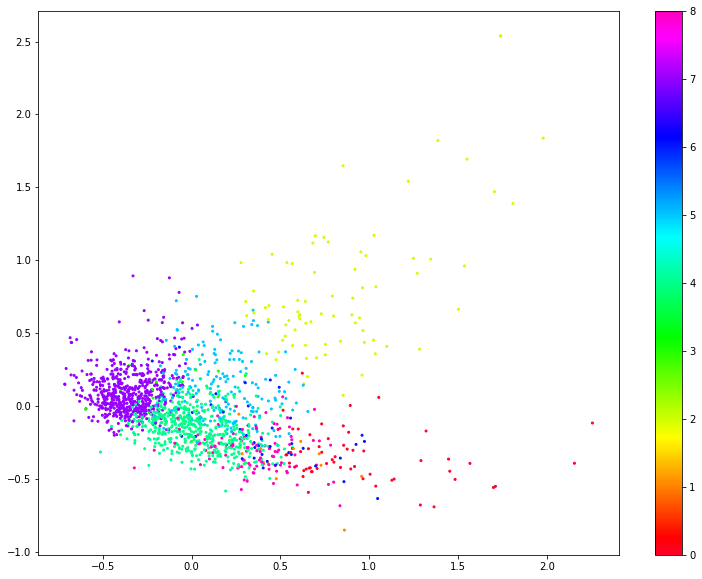

In [69]:
parse_results(pred, "som_" + str(m*n), centers)

### Sauvegarder le modèle et les poids

In [70]:
import pickle

dir = cluster_dir + "som_" + str(m*n) + "/"

with open(dir + 'som.p', 'wb') as outfile:
    pickle.dump(som, outfile)
    
np.save(dir + "som_weights.npy" ,som.get_weights())